Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


# Phase 2 Project

### Importing Data

In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('Data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


#### Formatting Cell

In [2]:
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed

## Glossary

### Column Names and descriptions for Kings County Data Set
(source: Data/column_names.md)
* **id** - unique identified for a house
* **date** - house was sold
* **price** -  is prediction target
* **bedrooms** -  of Bedrooms/House
* **bathrooms** -  of bathrooms/bedrooms
* **sqft_livings** -  footage of the home
* **sqft_lots** -  footage of the lot
* **floors** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

### Building Condition Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)

Relative to age and grade. Coded 1-5.

1 = Poor- Worn out. Repair and overhaul needed on painted surfaces, roofing, plumbing, heating and numerous functional inadequacies. Excessive deferred maintenance and abuse, limited value-in-use, approaching abandonment or major reconstruction; reuse or change in occupancy is imminent. Effective age is near the end of the scale regardless of the actual chronological age.

2 = Fair- Badly worn. Much repair needed. Many items need refinishing or overhauling, deferred maintenance obvious, inadequate building utility and systems all shortening the life expectancy and increasing the effective age.

3 = Average- Some evidence of deferred maintenance and normal obsolescence with age in that a few minor repairs are needed, along with some refinishing. All major components still functional and contributing toward an extended life expectancy. Effective age and utility is standard for like properties of its class and usage.

4 = Good- No obvious maintenance required but neither is everything new. Appearance and utility are above the standard and the overall effective age will be lower than the typical property.

5= Very Good- All items well maintained, many having been overhauled and repaired as they have shown signs of wear, increasing the life expectancy and lowering the effective age with little deterioration or obsolescence evident with a high degree of utility.


### Building Grade Explaination
https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#d (accessed 12/6/2021)


Represents the construction quality of improvements. Grades run from grade 1 to 13. Generally defined as:

1-3 Falls short of minimum building standards. Normally cabin or inferior structure.

4 Generally older, low quality construction. Does not meet code.

5 Low construction costs and workmanship. Small, simple design.

6 Lowest grade currently meeting building code. Low quality materials and simple designs.

7 Average grade of construction and design. Commonly seen in plats and older sub-divisions.

8 Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

9 Better architectural design with extra interior and exterior design and quality.

10 Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

11 Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

12 Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

13 Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

# Data Cleaning

## Dropping Uncessary Columns

In [3]:
df = df.drop(df[['id', 'date', 'view', 'lat', 'long', 'yr_renovated']], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,3,7,1180,0.0,1955,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,98074,1800,7503


## Checking Data Types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     19221 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  zipcode        21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.5+ MB


In [5]:
#7 records have 3.5 floors. I could drop those records, or perhaps change the value of 3.0 to "3 or more"
#df.sort_values('floors', ascending=False).head(100)

### Removing the ? in sqft_basement

In [6]:
unknown_basements = df[df['sqft_basement'] == '?']
known_basements = df[df['sqft_basement'] != '?']

print('Unkown Basement:',(len(unknown_basements)))
print('Known Basement:',(len(known_basements)))

Unkown Basement: 454
Known Basement: 21143


In [7]:
sqft_basement = unknown_basements.apply(lambda x: x['sqft_living'] - x['sqft_above'], axis=1)
unknown_basements['sqft_basement'] = sqft_basement

cleaned_df = known_basements.append(unknown_basements)

#changing to float so that decminals are in the same format
cleaned_df['sqft_basement'] = cleaned_df['sqft_basement'].astype(float)
cleaned_df['sqft_above'] = cleaned_df['sqft_above'].astype(float)

cleaned_df['sqft_basement'].value_counts().head()

<ipython-input-7-1fc1beccaa25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_basements['sqft_basement'] = sqft_basement


0.0      13110
600.0      221
700.0      218
500.0      214
800.0      206
Name: sqft_basement, dtype: int64

### Changing Zip Code to Category

In [8]:
cleaned_df['zipcode'] = df['zipcode'].astype(str)
cleaned_df['zipcode'].value_counts().head()

98103    602
98038    589
98115    583
98052    574
98117    553
Name: zipcode, dtype: int64

### Dropping Bedroom Outliers

In [9]:
#cleaned_df['bedrooms'].value_counts()

In [10]:
#dropping outliers
cleaned_df = cleaned_df.sort_values('bedrooms', ascending=False).reset_index()
cleaned_df = cleaned_df.drop([0,1,2])
cleaned_df.head(5)

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,19239,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745
4,13301,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2008,98004,2730,10400
5,8537,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1996,98144,1448,3866
6,18428,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,98105,2460,4400
7,4231,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,98102,1960,2450


In [11]:
#dropping index
cleaned_df = cleaned_df.drop(['index'], axis=1)

In [12]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21594 entries, 3 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21594 non-null  float64
 1   bedrooms       21594 non-null  int64  
 2   bathrooms      21594 non-null  float64
 3   sqft_living    21594 non-null  int64  
 4   sqft_lot       21594 non-null  int64  
 5   floors         21594 non-null  float64
 6   waterfront     19218 non-null  float64
 7   condition      21594 non-null  int64  
 8   grade          21594 non-null  int64  
 9   sqft_above     21594 non-null  float64
 10  sqft_basement  21594 non-null  float64
 11  yr_built       21594 non-null  int64  
 12  zipcode        21594 non-null  object 
 13  sqft_living15  21594 non-null  int64  
 14  sqft_lot15     21594 non-null  int64  
dtypes: float64(6), int64(8), object(1)
memory usage: 2.6+ MB


### Exploring Data with Scatter Plot

In [13]:
#using scatter plot to look for linear relationships
#pd.plotting.scatter_matrix(cleaned_df, figsize = [20,20]);
#plt.show()

### Analysis:
At first glance, the following variables seem to have linear relationships:
- price with bedrooms, sqft_above, & sqft_basement.
    - price also seems to have a linear relationship with categorical variable 'grade'.
- bedrooms with bathrooms, sqft_living, sqft_above, & sqft_basement
- sqft_living and sqft_above have the closest linear relationship
    - They are very similar data points. I may need to eliminate one to prevent multicolinearity.
    
The Following Variables seem to be categorical:
- floors
- waterfront
- condition
- zip code (not shown because I have already made it an object)

Ordinal Variables:
- bedrooms
- bathrooms



### What To Do with the Ordinal Values

I am going to treat grade as a continuous variable as it has very linear relationships with many features. Including price.

## Checking for Null Values

In [14]:
cleaned_df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
zipcode             0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Fixing Waterfront

In [15]:
#cleaned_df['waterfront'].value_counts()

In [16]:
waterfront_cleaned = cleaned_df['waterfront'].fillna(0) 
cleaned_df['waterfront'] = waterfront_cleaned
cleaned_df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
zipcode          0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Building Condition

Should I change the condition values from numbers to words?

## Bedrooms

Should I change bedrooms so that there are less options? ie, <1 instead of 0, 0.5, etc

# Exploratory Data Analysis

In [21]:
cleaned_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
count,2.159400e+04,21594.000000,21594.000000,21594.000000,2.159400e+04,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000,21594.000000
mean,5.402878e+05,3.371168,2.115808,2080.229740,1.510045e+04,1.494072,0.006761,3.409743,7.658007,1788.546633,291.683106,1971.003844,1986.674493,12759.056914
std,3.673922e+05,0.901536,0.769010,918.084207,4.141540e+04,0.539688,0.081950,0.650482,1.173256,827.749396,442.684260,29.374473,685.252555,27276.229189
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,1.000000,3.000000,370.000000,0.000000,1900.000000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.619000e+03,1.500000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068475e+04,2.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,2360.000000,10082.250000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,6210.000000,871200.000000


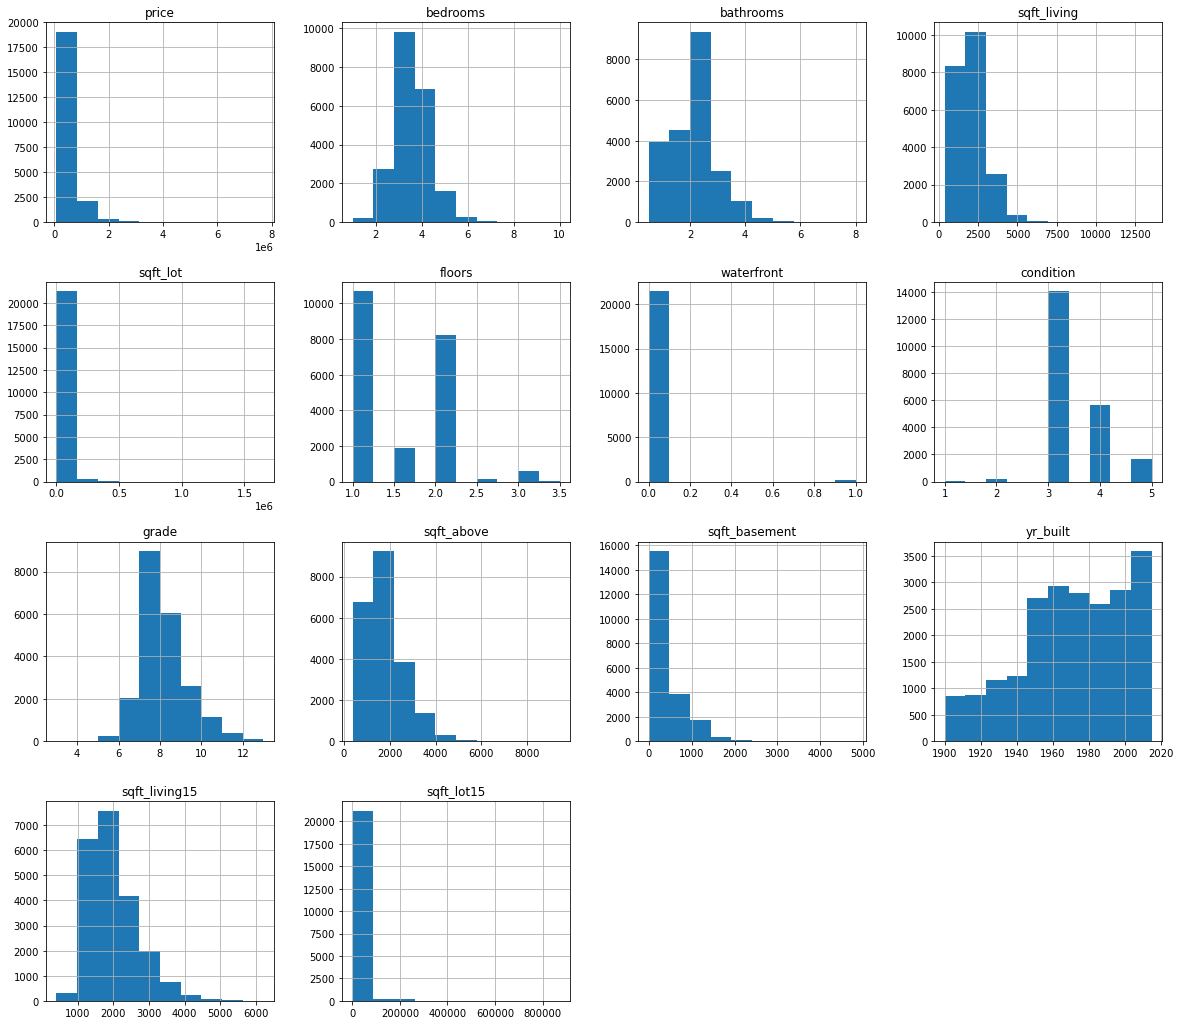

In [18]:
cleaned_df.hist(figsize = (20,18));

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


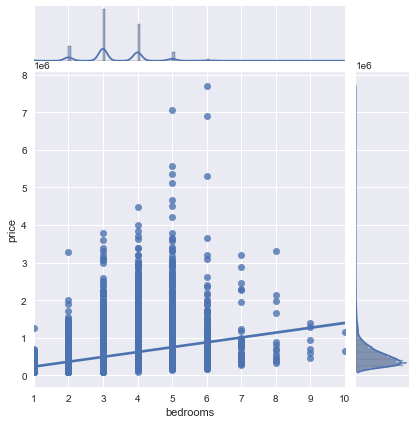

In [23]:
sns.jointplot('bedrooms','price', data=cleaned_df, kind='reg');

In [ ]:
# Slight Linearity?

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


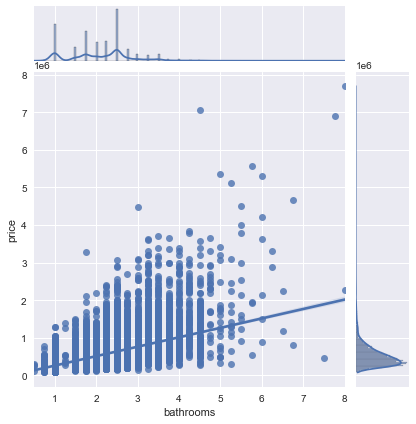

In [24]:
sns.jointplot('bathrooms','price', data=cleaned_df, kind='reg');

In [ ]:
# Fairly Linear. Especially if I remove the outliers.

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


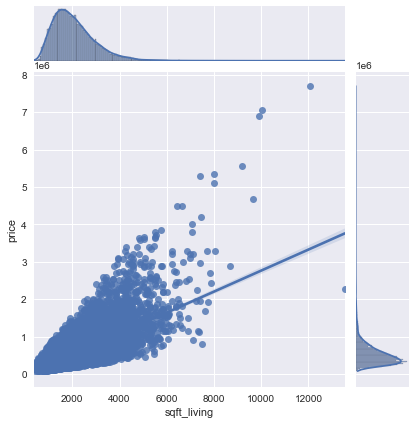

In [25]:
sns.jointplot('sqft_living','price', data=cleaned_df, kind='reg');

In [ ]:
# VERY linear relationship. Normal-ish distribution.

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


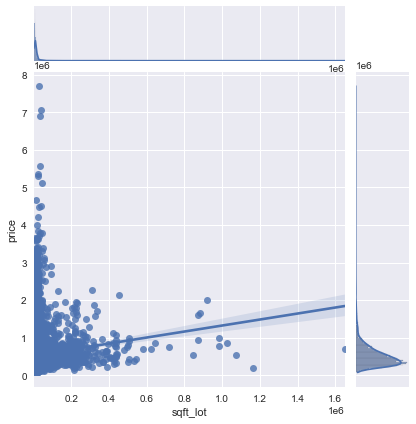

In [26]:
sns.jointplot('sqft_lot','price', data=cleaned_df, kind='reg');

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


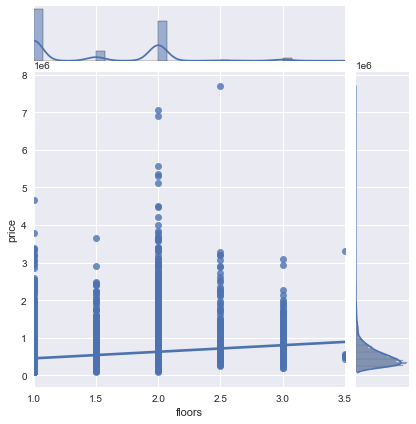

In [27]:
sns.jointplot('floors','price', data=cleaned_df, kind='reg');

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


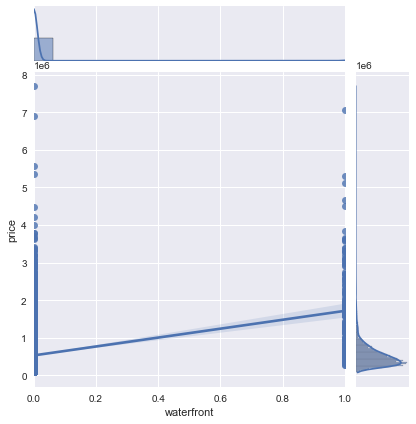

In [28]:
sns.jointplot('waterfront','price', data=cleaned_df, kind='reg');

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


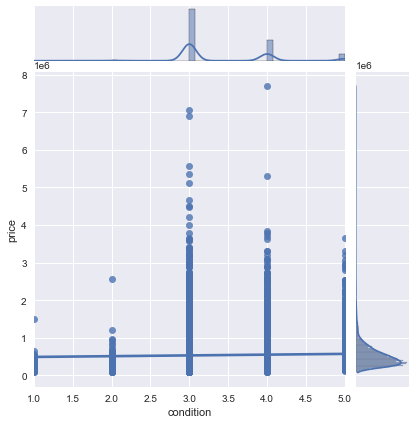

In [29]:
sns.jointplot('condition','price', data=cleaned_df, kind='reg');

In [ ]:
#interestingly, condition doesn't appear to have an affect on price.

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


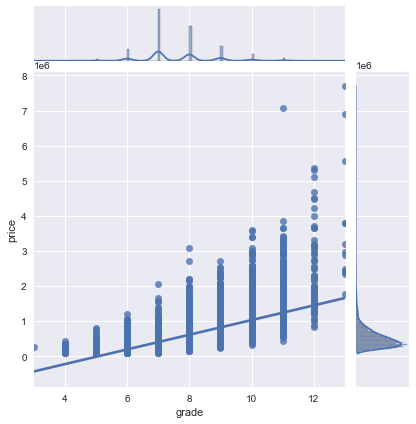

In [30]:
sns.jointplot('grade','price', data=cleaned_df, kind='reg');

In [ ]:
#linear relationship with a little noise

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


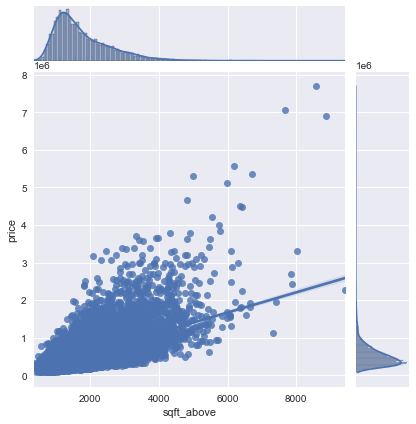

In [31]:
sns.jointplot('sqft_above','price', data=cleaned_df, kind='reg');

In [ ]:
#as expected. Very linear.

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


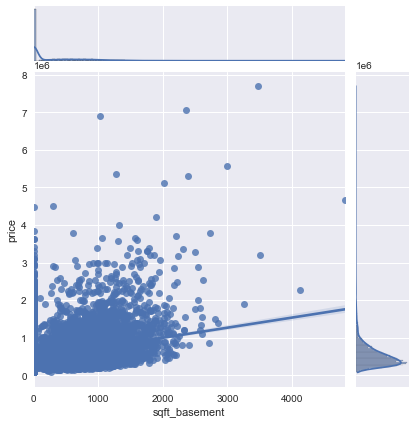

In [32]:
sns.jointplot('sqft_basement','price', data=cleaned_df, kind='reg');

In [ ]:
#slight linear relationship

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


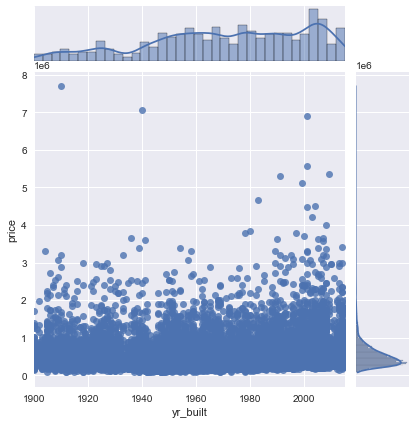

In [33]:
sns.jointplot('yr_built','price', data=cleaned_df, kind='reg');

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


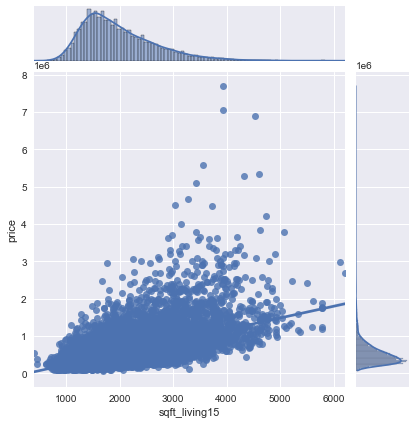

In [34]:
sns.jointplot('sqft_living15','price', data=cleaned_df, kind='reg');

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


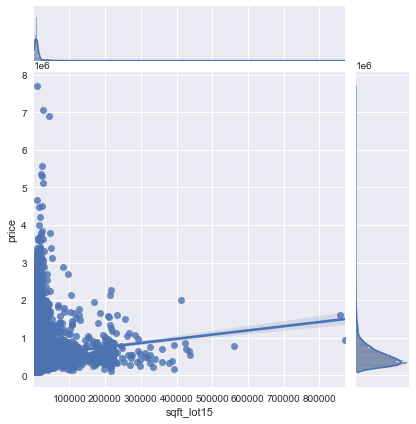

In [35]:
sns.jointplot('sqft_lot15','price', data=cleaned_df, kind='reg');

### Analysis of Jointplots
- As the data currently stands, sqft_living, sqft_above, and sqft_living15 are my best predictors.
- bedrooms, bathrooms, grade, sqft_lot, sqft_basement, and sqft_lot15 also show linear relationships and could possibly be improved
- condition and yr_built don't have linear relationships and therefore not much prediction power.

In [37]:
feats = ['sqft_living', 'sqft_above', 'sqft_living15','bedrooms','bathrooms', 'grade', 'sqft_lot',
         'sqft_basement','sqft_lot15']
corr = cleaned_df[feats].corr()
corr

,sqft_living,sqft_above,sqft_living15,bedrooms,bathrooms,grade,sqft_lot,sqft_basement,sqft_lot15
sqft_living,1.000000,0.876432,0.756510,0.593994,0.755803,0.762923,0.173482,0.435114,0.184369
sqft_above,0.876432,1.000000,0.731837,0.493213,0.686700,0.756185,0.184159,-0.052206,0.195094
sqft_living15,0.756510,0.731837,1.000000,0.406011,0.569949,0.713865,0.144749,0.200510,0.183499
bedrooms,0.593994,0.493213,0.406011,1.000000,0.529021,0.367654,0.033822,0.309656,0.032107
bathrooms,0.755803,0.686700,0.569949,0.529021,1.000000,0.665890,0.088384,0.283441,0.088315
grade,0.762923,0.756185,0.713865,0.367654,0.665890,1.000000,0.114720,0.168282,0.120968
sqft_lot,0.173482,0.184159,0.144749,0.033822,0.088384,0.114720,1.000000,0.015435,0.718202
sqft_basement,0.435114,-0.052206,0.200510,0.309656,0.283441,0.168282,0.015435,1.000000,0.017570
sqft_lot15,0.184369,0.195094,0.183499,0.032107,0.088315,0.120968,0.718202,0.017570,1.000000


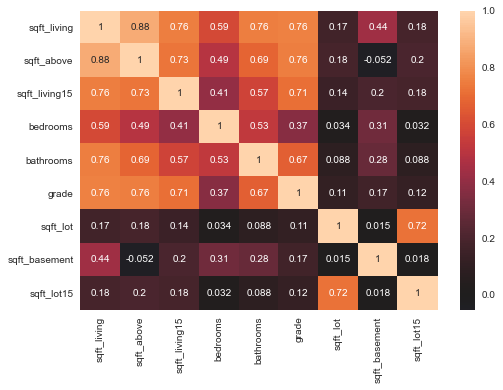

In [38]:
sns.heatmap(corr, center=0, annot=True);

# Initial Modeling 

## Baseline Model
- running a model with the cleaned data.

In [17]:
# drop zipcode before running base model
base_df = cleaned_df
base_df = base_df.drop(base_df[['zipcode']], axis=1)
base_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
3,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,1810,3745
4,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2008,2730,10400
5,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1996,1448,3866
6,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,1918,2460,4400
7,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1908,1960,2450


In [18]:
X = base_df.drop(['price'], axis=1)
y = base_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     3322.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:11:26   Log-Likelihood:            -2.9605e+05
No. Observations:               21594   AIC:                         5.921e+05
Df Residuals:                   21581   BIC:                         5.922e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.672e+06   1.31e+05     50.900      0.000    6.42e+06    6.93e+06
bedrooms      -4.708e+04   2136.740    -22.033      0.000   -5.13e+04   -4.29e+04
bathrooms      5.034e+04   3509.444     14.346      0.000    4.35e+04    5.72e+04
sqft_living     114.9032      2.463     46.643      0.000     110.075     119.732
sqft_lot          0.0246      0.052      0.475      0.635      -0.077       0.126
floors         3.005e+04   3814.813      7.878      0.000    2.26e+04    3.75e+04
waterfront     7.495e+05   1.83e+04     40.952      0.000    7.14e+05    7.85e+05
condition      1.895e+04   2483.781      7.631      0.000    1.41e+04    2.38e+04
grade          1.239e+05   2269.284     54.583      0.000    1.19e+05    1.28e+05
sqft_above       46.6691      2.360     19.772      0.000      42.043      51.296
sqft_basement    68.2337      2.758     24.740      0.000      62.828      73.640
yr_built      -3828.2971     67.288    -56.894      0.000   -3960.186   -3696.408
sqft_living15    33.7797      3.597      9.392      0.000      26.730      40.830
sqft_lot15       -0.5649      0.079     -7.147      0.000      -0.720      -0.410
==============================================================================
Omnibus:                    16213.002   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1122803.321
Skew:                           3.017   Prob(JB):                         0.00
Kurtosis:                      37.806   Cond. No.                     3.29e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.11e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Baseline Normalization

In [19]:
def norm_feat(series):
    return (series - series.mean())/series.std()

In [20]:
df_base_norm = norm_feat(base_df)
df_base_norm.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
3,0.325843,7.352819,1.149780,0.914699,-0.274184,0.937445,-0.082504,0.907414,-0.560838,0.086322,1.735587,-1.974634,-0.257824,-0.330473
4,1.659567,7.352819,4.075621,2.733704,-0.100939,-0.915478,-0.082504,-0.629907,1.143820,0.859503,4.062301,1.259466,1.084747,-0.086488
5,-0.245753,6.243601,7.001462,2.145522,-0.207566,0.937445,-0.082504,-0.629907,-0.560838,2.732051,-0.658896,0.850948,-0.786096,-0.326037
6,1.071640,6.243601,1.149780,0.805776,-0.256437,0.937445,-0.082504,-0.629907,-0.560838,0.110484,1.464513,-1.804419,0.690731,-0.306459
7,0.434718,6.243601,1.149780,1.742509,-0.258369,0.937445,-0.082504,-0.629907,-0.560838,1.258175,1.261208,-2.144850,-0.038927,-0.377950


In [21]:
X = df_base_norm.drop('price', axis=1)
y = df_base_norm['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     3321.
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:11:26   Log-Likelihood:                -19344.
No. Observations:               21594   AIC:                         3.871e+04
Df Residuals:                   21581   BIC:                         3.882e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0022      0.005     -0.462      0.644      -0.012       0.007
bedrooms         -0.1167      0.005    -21.569      0.000      -0.127      -0.106
bathrooms         0.1033      0.008     13.311      0.000       0.088       0.118
sqft_living   -4.532e+11   5.31e+11     -0.854      0.393   -1.49e+12    5.87e+11
sqft_lot          0.0026      0.006      0.453      0.651      -0.009       0.014
floors            0.0434      0.006      7.659      0.000       0.032       0.055
waterfront        0.1672      0.004     40.946      0.000       0.159       0.175
condition         0.0337      0.004      7.655      0.000       0.025       0.042
grade             0.3956      0.007     54.588      0.000       0.381       0.410
sqft_above     4.086e+11   4.79e+11      0.854      0.393    -5.3e+11    1.35e+12
sqft_basement  2.185e+11   2.56e+11      0.854      0.393   -2.83e+11     7.2e+11
yr_built         -0.3060      0.005    -56.869      0.000      -0.317      -0.295
sqft_living15     0.0631      0.007      9.404      0.000       0.050       0.076
sqft_lot15       -0.0419      0.006     -7.139      0.000      -0.053      -0.030
==============================================================================
Omnibus:                    16081.087   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1095569.575
Skew:                           2.983   Prob(JB):                         0.00
Kurtosis:                      37.381   Cond. No.                     4.18e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.1e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Checking for Multicolinearity

In [22]:
#numeric variables
numeric_vars= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront',
'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']

#numeric_vars= ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront',
#'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
numeric_vars

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15']

In [23]:
cleaned_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745


In [24]:
num_var_df = cleaned_df.loc[:,numeric_vars]
num_var_df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
3,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1810,3745
4,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2730,10400
5,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1448,3866
6,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,2460,4400
7,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1960,2450


In [25]:
#scatter matrix for numeric variables
#pd.plotting.scatter_matrix(king_preprocessed, figsize=[20, 20]);

In [26]:
#correlation matrix
num_var_df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
price,1.000000,0.316799,0.525938,0.701971,0.089880,0.256821,0.264309,0.036018,0.667981,0.605413,0.323795,0.585274,0.082849
bedrooms,0.316799,1.000000,0.529021,0.593994,0.033822,0.183562,-0.002000,0.023447,0.367654,0.493213,0.309656,0.406011,0.032107
bathrooms,0.525938,0.529021,1.000000,0.755803,0.088384,0.502567,0.063634,-0.126411,0.665890,0.686700,0.283441,0.569949,0.088315
sqft_living,0.701971,0.593994,0.755803,1.000000,0.173482,0.353871,0.104655,-0.059444,0.762923,0.876432,0.435114,0.756510,0.184369
sqft_lot,0.089880,0.033822,0.088384,0.173482,1.000000,-0.004810,0.021457,-0.008810,0.114720,0.184159,0.015435,0.144749,0.718202
floors,0.256821,0.183562,0.502567,0.353871,-0.004810,1.000000,0.020802,-0.264044,0.458857,0.523929,-0.245770,0.280121,-0.010721
waterfront,0.264309,-0.002000,0.063634,0.104655,0.021457,0.020802,1.000000,0.016661,0.082814,0.071789,0.082810,0.083820,0.030656
condition,0.036018,0.023447,-0.126411,-0.059444,-0.008810,-0.264044,0.016661,1.000000,-0.146853,-0.158881,0.173801,-0.093010,-0.003100
grade,0.667981,0.367654,0.665890,0.762923,0.114720,0.458857,0.082814,-0.146853,1.000000,0.756185,0.168282,0.713865,0.120968
sqft_above,0.605413,0.493213,0.686700,0.876432,0.184159,0.523929,0.071789,-0.158881,0.756185,1.000000,-0.052206,0.731837,0.195094


In [27]:
#abs(king_preprocessed.corr()) > 0.75

In [28]:
cc_df = num_var_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

,cc
pairs,
"(sqft_above, sqft_living)",0.876432
"(sqft_living, grade)",0.762923
"(sqft_living15, sqft_living)",0.756510
"(grade, sqft_above)",0.756185
"(bathrooms, sqft_living)",0.755803


I need to remove some of these variables to prevent multicolineartiy. 


### Multicollinearity Analysis

There are 5 sets of variables that are highly correlated.  

In [29]:
#removing these two variables removes all of the colinearity pairs
#king_preprocessed.drop(columns=['sqft_above', 'sqft_living'], inplace=True)

In [30]:
num_var_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1810,3745


In [31]:
col_test_df = num_var_df
col_test_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15
3,660000.0,10,3.00,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1810,3745
4,1150000.0,10,5.25,4590,10920,1.0,0.0,3,9,2500.0,2090.0,2730,10400
5,450000.0,9,7.50,4050,6504,2.0,0.0,3,7,4050.0,0.0,1448,3866
6,934000.0,9,3.00,2820,4480,2.0,0.0,3,7,1880.0,940.0,2460,4400
7,700000.0,9,3.00,3680,4400,2.0,0.0,3,7,2830.0,850.0,1960,2450
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,227000.0,1,2.00,1150,9812,1.0,0.0,4,7,1150.0,0.0,1200,9812
21593,199900.0,1,1.00,720,7140,1.0,0.0,3,6,720.0,0.0,1140,7577
21594,330600.0,1,1.00,580,1799,1.0,0.0,3,7,580.0,0.0,1260,4000
21595,385195.0,1,1.00,710,6000,1.5,0.0,3,6,710.0,0.0,1440,4800


In [32]:
col_test_df = col_test_df.drop(columns=['grade', 'sqft_living'], axis=1)
col_test_df.head(1)

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,sqft_living15,sqft_lot15
3,660000.0,10,3.0,3745,2.0,0.0,4,1860.0,1060.0,1810,3745


In [33]:
cc_df = col_test_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

cc_df['pairs'] = list(zip(cc_df.level_0, cc_df.level_1))

cc_df.set_index(['pairs'], inplace = True)

cc_df.drop(columns=['level_1', 'level_0'], inplace = True)

# cc for correlation coefficient
cc_df.columns = ['cc']

cc_df.drop_duplicates(inplace=True)

cc_df[(cc_df.cc>.75) & (cc_df.cc<1)]

,cc
pairs,


## Check VIF Scores!!!!

In [ ]:
#def variance_inflation_factors(exog_df):
#    exog_df = add_constant(exog_df)
#    vifs = pd.Series(
#        [1 / (1. - OLS(exog_df[col].values, 
#                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
#         for col in exog_df],
#        index=exog_df.columns,
#        name='VIF'
#    )
#    return vifs

# Model #2

## Make Changes to Model HERE!

In [36]:
cleaned_df.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,4,7,1860.0,1060.0,1913,98105,1810,3745


In [40]:
# drop more columns?
changed_df = cleaned_df
changed_df = changed_df.drop(changed_df[['grade', 'sqft_above']], axis=1)
#changed_df.head()

In [43]:
model_2 = changed_df
model_2.head(1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.0,2920,3745,2.0,0.0,4,1060.0,1913,98105,1810,3745


In [ ]:
#one-hot encoding
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
#feats = ['bedrooms','waterfront', 'condition']
#changed_df[feats] = changed_df[feats].astype(str)
#changed_df = pd.get_dummies(changed_df, drop_first=True)

In [39]:
#for Model 2 I am encoding waterfront and zipcode
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
feats = ['waterfront', 'zipcode']
model_2[feats] = model_2[feats].astype(str)
model_2 = pd.get_dummies(model_2, drop_first=True)
model_2.head()

NameError: name 'model_2' is not defined

## Run Model #2

In [45]:
#df_norm.head()
test_df = model_2

In [46]:
X = test_df.drop('price', axis=1)
y = test_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()X = test_df.drop('price', axis=1)
y = test_df['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     995.7
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:26:32   Log-Likelihood:            -2.9063e+05
No. Observations:               21594   AIC:                         5.814e+05
Df Residuals:                   21513   BIC:                         5.821e+05
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           6.235e+05   1.23e+05      5.049      0.000    3.81e+05    8.66e+05
bedrooms       -4.108e+04   1681.886    -24.424      0.000   -4.44e+04   -3.78e+04
bathrooms       3.475e+04   2754.831     12.613      0.000    2.93e+04    4.01e+04
sqft_living      252.4868      2.909     86.800      0.000     246.785     258.188
sqft_lot           0.3042      0.041      7.504      0.000       0.225       0.384
floors         -3.808e+04   3328.356    -11.441      0.000   -4.46e+04   -3.16e+04
condition       2.463e+04   2000.724     12.312      0.000    2.07e+04    2.86e+04
sqft_basement    -82.2022      3.733    -22.019      0.000     -89.519     -74.885
yr_built        -436.4876     62.187     -7.019      0.000    -558.378    -314.597
sqft_living15     52.2834      2.892     18.077      0.000      46.614      57.952
sqft_lot15        -0.1758      0.064     -2.755      0.006      -0.301      -0.051
waterfront_1.0   8.68e+05   1.46e+04     59.645      0.000    8.39e+05    8.97e+05
zipcode_98002   2.042e+04    1.5e+04      1.359      0.174   -9039.124    4.99e+04
zipcode_98003   2326.0583   1.35e+04      0.172      0.863   -2.42e+04    2.88e+04
zipcode_98004   7.939e+05   1.32e+04     60.052      0.000    7.68e+05     8.2e+05
zipcode_98005   3.111e+05    1.6e+04     19.488      0.000     2.8e+05    3.42e+05
zipcode_98006   2.993e+05   1.19e+04     25.045      0.000    2.76e+05    3.23e+05
zipcode_98007   2.604e+05   1.69e+04     15.417      0.000    2.27e+05    2.93e+05
zipcode_98008   2.771e+05   1.35e+04     20.481      0.000    2.51e+05    3.04e+05
zipcode_98010   5.625e+04   1.93e+04      2.919      0.004    1.85e+04     9.4e+04
zipcode_98011   1.129e+05   1.51e+04      7.471      0.000    8.33e+04    1.43e+05
zipcode_98014   8.811e+04    1.8e+04      4.902      0.000    5.29e+04    1.23e+05
zipcode_98019   6.626e+04   1.53e+04      4.335      0.000    3.63e+04    9.62e+04
zipcode_98022   1.273e+04   1.44e+04      0.882      0.378   -1.56e+04     4.1e+04
zipcode_98023  -2.539e+04   1.17e+04     -2.163      0.031   -4.84e+04   -2384.125
zipcode_98024   1.457e+05   2.12e+04      6.860      0.000    1.04e+05    1.87e+05
zipcode_98027   1.649e+05   1.23e+04     13.372      0.000    1.41e+05    1.89e+05
zipcode_98028   1.215e+05   1.35e+04      8.999      0.000     9.5e+04    1.48e+05
zipcode_98029   2.243e+05   1.31e+04     17.118      0.000    1.99e+05     2.5e+05
zipcode_98030   -942.9296   1.39e+04     -0.068      0.946   -2.81e+04    2.63e+04
zipcode_98031   8669.2746   1.36e+04      0.636      0.525    -1.8e+04    3.54e+04
zipcode_98032   2.005e+04   1.76e+04      1.137      0.256   -1.45e+04    5.46e+04
zipcode_98033   3.824e+05   1.21e+04     31.490      0.000    3.59e+05    4.06e+05
zipcode_98034   2.135e+05   1.15e+04     18.507      0.000    1.91e+05    2.36e+05
zipcode_9803

### Model #2 Normalized

In [47]:
model_2_norm = norm_feat(model_2)
model_2_norm.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_basement,yr_built,sqft_living15,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,0.325843,7.352819,1.149780,0.914699,-0.274184,0.937445,0.907414,1.735587,-1.974634,-0.257824,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
4,1.659567,7.352819,4.075621,2.733704,-0.100939,-0.915478,-0.629907,4.062301,1.259466,1.084747,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
5,-0.245753,6.243601,7.001462,2.145522,-0.207566,0.937445,-0.629907,-0.658896,0.850948,-0.786096,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
6,1.071640,6.243601,1.149780,0.805776,-0.256437,0.937445,-0.629907,1.464513,-1.804419,0.690731,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057
7,0.434718,6.243601,1.149780,1.742509,-0.258369,0.937445,-0.629907,1.261208,-2.144850,-0.038927,...,-0.116261,-0.051444,-0.145219,-0.109096,-0.112311,-0.109313,-0.110822,-0.079609,-0.114614,-0.122057


In [48]:
X = model_2_norm.drop('price', axis=1)
y = model_2_norm['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     995.7
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:31:23   Log-Likelihood:                -13925.
No. Observations:               21594   AIC:                         2.801e+04
Df Residuals:                   21513   BIC:                         2.866e+04
Df Model:                          80                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.869e-15      0.003   1.87e-12      1.000      -0.006       0.006
bedrooms          -0.1008      0.004    -24.424      0.000      -0.109      -0.093
bathrooms          0.0727      0.006     12.613      0.000       0.061       0.084
sqft_living        0.6309      0.007     86.800      0.000       0.617       0.645
sqft_lot           0.0343      0.005      7.504      0.000       0.025       0.043
floors            -0.0559      0.005    -11.441      0.000      -0.066      -0.046
condition          0.0436      0.004     12.312      0.000       0.037       0.051
sqft_basement     -0.0990      0.004    -22.019      0.000      -0.108      -0.090
yr_built          -0.0349      0.005     -7.019      0.000      -0.045      -0.025
sqft_living15      0.0975      0.005     18.077      0.000       0.087       0.108
sqft_lot15        -0.0131      0.005     -2.755      0.006      -0.022      -0.004
waterfront_1.0     0.1936      0.003     59.645      0.000       0.187       0.200
zipcode_98002      0.0053      0.004      1.359      0.174      -0.002       0.013
zipcode_98003      0.0007      0.004      0.172      0.863      -0.007       0.009
zipcode_98004      0.2599      0.004     60.052      0.000       0.251       0.268
zipcode_98005      0.0744      0.004     19.488      0.000       0.067       0.082
zipcode_98006      0.1221      0.005     25.045      0.000       0.113       0.132
zipcode_98007      0.0571      0.004     15.417      0.000       0.050       0.064
zipcode_98008      0.0858      0.004     20.481      0.000       0.078       0.094
zipcode_98010      0.0104      0.004      2.919      0.004       0.003       0.017
zipcode_98011      0.0291      0.004      7.471      0.000       0.021       0.037
zipcode_98014      0.0181      0.004      4.902      0.000       0.011       0.025
zipcode_98019      0.0168      0.004      4.335      0.000       0.009       0.024
zipcode_98022      0.0036      0.004      0.882      0.378      -0.004       0.012
zipcode_98023     -0.0104      0.005     -2.163      0.031      -0.020      -0.001
zipcode_98024      0.0241      0.004      6.860      0.000       0.017       0.031
zipcode_98027      0.0614      0.005     13.372      0.000       0.052       0.070
zipcode_98028      0.0376      0.004      8.999      0.000       0.029       0.046
zipcode_98029      0.0739      0.004     17.118      0.000       0.065       0.082
zipcode_98030     -0.0003      0.004     -0.068      0.946      -0.008       0.008
zipcode_98031      0.0026      0.004      0.636      0.525      -0.005       0.011
zipcode_98032      0.0041      0.004      1.137      0.256      -0.003       0.011
zipcode_98033      0.1457      0.005     31.490      0.000       0.137       0.155
zipcode_98034      0.0911      0.005     18.507      0.000       0.081       0.101
zipcode_9803

# Model #3
- model 3 has all of the features encoded.

In [49]:
model_3 = changed_df
model_3.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15
3,660000.0,10,3.00,2920,3745,2.0,0.0,4,1060.0,1913,98105,1810,3745
4,1150000.0,10,5.25,4590,10920,1.0,0.0,3,2090.0,2008,98004,2730,10400
5,450000.0,9,7.50,4050,6504,2.0,0.0,3,0.0,1996,98144,1448,3866
6,934000.0,9,3.00,2820,4480,2.0,0.0,3,940.0,1918,98105,2460,4400
7,700000.0,9,3.00,3680,4400,2.0,0.0,3,850.0,1908,98102,1960,2450


In [50]:
feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
model_3[feats] = model_3[feats].astype(str)
model_3 = pd.get_dummies(model_3, drop_first=True)
model_3.head()

,price,bathrooms,sqft_living,sqft_lot,sqft_basement,yr_built,sqft_living15,sqft_lot15,bedrooms_10,bedrooms_2,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
3,660000.0,3.00,2920,3745,1060.0,1913,1810,3745,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1150000.0,5.25,4590,10920,2090.0,2008,2730,10400,1,0,...,0,0,0,0,0,0,0,0,0,0
5,450000.0,7.50,4050,6504,0.0,1996,1448,3866,0,0,...,0,0,0,0,0,0,0,0,0,0
6,934000.0,3.00,2820,4480,940.0,1918,2460,4400,0,0,...,0,0,0,0,0,0,0,0,0,0
7,700000.0,3.00,3680,4400,850.0,1908,1960,2450,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
#df_norm.head()
X = model_3.drop('price', axis=1)
y = model_3['price']

X_int = sm.add_constant(X)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     845.9
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        20:51:05   Log-Likelihood:            -2.9055e+05
No. Observations:               21594   AIC:                         5.813e+05
Df Residuals:                   21498   BIC:                         5.821e+05
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.236e+05   1.34e+05      3.895      0.000     2.6e+05    7.87e+05
bathrooms       3.522e+04   2772.275     12.704      0.000    2.98e+04    4.07e+04
sqft_living      253.5091      2.940     86.213      0.000     247.746     259.273
sqft_lot           0.3048      0.040      7.533      0.000       0.225       0.384
sqft_basement    -86.6017      3.800    -22.789      0.000     -94.050     -79.153
yr_built        -448.7804     67.211     -6.677      0.000    -580.519    -317.041
sqft_living15     54.3586      2.903     18.727      0.000      48.669      60.048
sqft_lot15        -0.1935      0.064     -3.039      0.002      -0.318      -0.069
bedrooms_10    -5.582e+05   1.21e+05     -4.627      0.000   -7.95e+05   -3.22e+05
bedrooms_2     -2.546e+04   1.26e+04     -2.022      0.043   -5.01e+04    -785.175
bedrooms_3     -6.106e+04   1.24e+04     -4.906      0.000   -8.55e+04   -3.67e+04
bedrooms_4      -1.11e+05   1.27e+04     -8.719      0.000   -1.36e+05    -8.6e+04
bedrooms_5     -1.383e+05   1.35e+04    -10.255      0.000   -1.65e+05   -1.12e+05
bedrooms_6      -1.69e+05   1.66e+04    -10.189      0.000   -2.02e+05   -1.37e+05
bedrooms_7     -2.949e+05   3.07e+04     -9.608      0.000   -3.55e+05   -2.35e+05
bedrooms_8      -1.94e+05   4.92e+04     -3.944      0.000    -2.9e+05   -9.76e+04
bedrooms_9      -4.64e+05   7.09e+04     -6.542      0.000   -6.03e+05   -3.25e+05
floors_1.5     -2.623e+04   4684.218     -5.599      0.000   -3.54e+04    -1.7e+04
floors_2.0     -5.063e+04   3892.741    -13.006      0.000   -5.83e+04    -4.3e+04
floors_2.5      5.657e+04   1.41e+04      4.012      0.000    2.89e+04    8.42e+04
floors_3.0     -6.241e+04   8661.465     -7.206      0.000   -7.94e+04   -4.54e+04
floors_3.5      3.431e+04   6.46e+04      0.531      0.595   -9.23e+04    1.61e+05
waterfront_1.0  8.673e+05   1.45e+04     59.757      0.000    8.39e+05    8.96e+05
condition_2       9.3e+04   3.41e+04      2.727      0.006    2.62e+04     1.6e+05
condition_3     1.016e+05   3.17e+04      3.209      0.001    3.95e+04    1.64e+05
condition_4     1.181e+05   3.17e+04      3.729      0.000     5.6e+04     1.8e+05
condition_5     1.571e+05   3.19e+04      4.929      0.000    9.46e+04     2.2e+05
zipcode_98002    2.16e+04    1.5e+04      1.441      0.150   -7776.913     5.1e+04
zipcode_98003   1889.8283   1.35e+04      0.140      0.889   -2.45e+04    2.83e+04
zipcode_98004   7.938e+05   1.32e+04     60.068      0.000    7.68e+05     8.2e+05
zipcode_98005   3.094e+05   1.59e+04     19.422      0.000    2.78e+05    3.41e+05
zipcode_98006   2.998e+05   1.19e+04     25.144      0.000    2.76e+05    3.23e+05
zipcode_98007   2.614e+05   1.69e+04     15.507      0.000    2.28e+05    2.94e+05
zipcode_98008   2.752e+05   1.35e+04     20.380      0.000    2.49e+05    3.02e+05
zipcode_9801

In [ ]:
#sns.pairplot(test_df)

In [ ]:
#sns.heatmap(king_preprocessed);

In [ ]:
king_preprocessed.head(1)

# Data Exploration

## One-Hot Encoding

In [ ]:
#feats = ['bedrooms','floors', 'waterfront', 'condition', 'zipcode']
feats = ['bedrooms','waterfront', 'condition']
cleaned_df[feats] = cleaned_df[feats].astype(str)
cleaned_df = pd.get_dummies(cleaned_df, drop_first=True)

# Modeling

# Archive

In [ ]:
#df['waterfront'].value_counts()

In [ ]:
#df['waterfront'] = df['waterfront'].astype('bool') #converting waterfront into boolean

## Resetting IDs to make them shorter

In [ ]:
X = test_df.drop('price', axis=1)
y = test_df['price']

## Should I drop low grade?

In [ ]:
low_grade = cleaned_df[cleaned_df['grade'] <= 5]
low_grade.head()

## Plotting Categoricals

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,10), sharey=True)

for col, ax in zip(categoricals, axes.flatten()):
    (king_preprocessed.groupby(col)               # group values together by column of interest
         .mean()['price']        # take the mean of the saleprice for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()


In [ ]:
#sns.heatmap(df_norm);

## One-Hot Encoding using Skilearn

In [ ]:
#trying sklearn method
ohe = OneHotEncoder(drop='first')

In [ ]:
data_trans = ohe.fit_transform(king_preprocessed)
data_trans.todense()

In [ ]:
data_trans = pd.DataFrame(data_trans.todense(), columns=ohe.get_feature_names())
data_trans.head()